In [4]:
import os
import random
import numpy as np
import torch
import pandas as pd
from google.colab.drive import mount
mount("/content/drive")
def set_all_seeds(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
set_all_seeds(144)

Mounted at /content/drive


In [5]:
!pip install torchmetrics torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: title={'center': 'Closing Price of Asset'}>

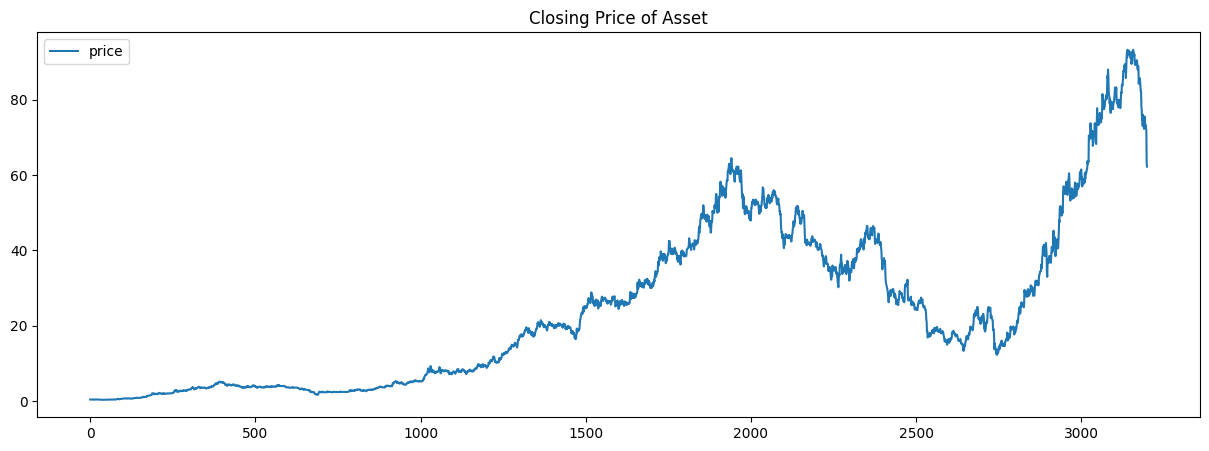

In [7]:
train_df = pd.read_csv("/content/drive/MyDrive/superai_ss3/hack_out/stock_investment/stock-investment-prediction/train.csv")
df =train_df[["price"]]
df.plot(figsize=(15,5), title="Closing Price of Asset")

In [8]:
ss = pd.read_csv("/content/drive/MyDrive/superai_ss3/hack_out/stock_investment/stock-investment-prediction/sample_submission.csv")
df = pd.concat([df, ss.dropna()[["price"]]], axis=0)
df = df.pct_change()[1:]
df = df.reset_index(drop=True)

<Axes: title={'center': 'Daily percentage change (Daily Return)'}>

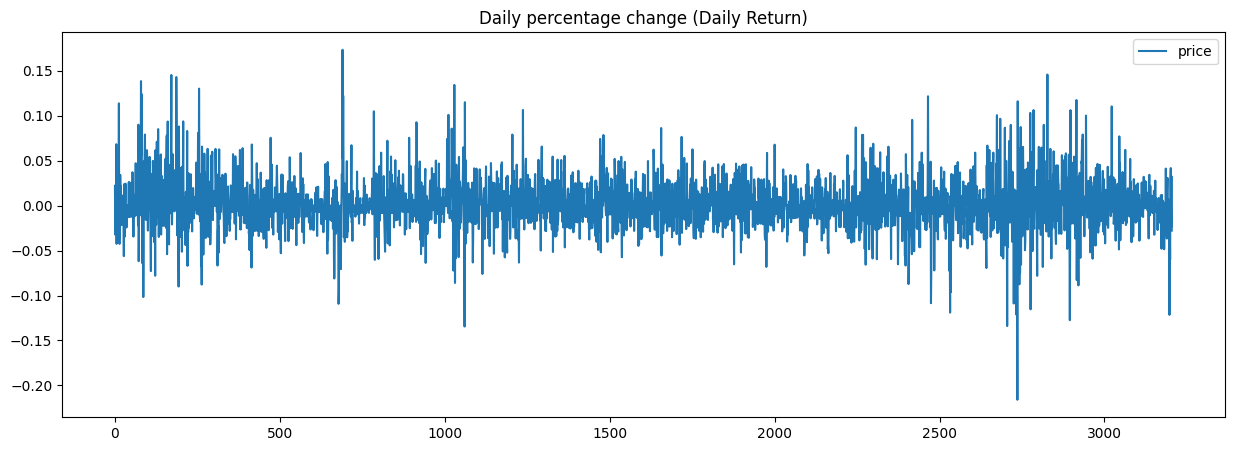

In [9]:
df.plot(figsize=(15,5), title = 'Daily percentage change (Daily Return)')

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
df_norm = scaler.transform(df)

In [11]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class Dataset_Custom(Dataset):
    def __init__(self, df, seq_len, pred_len):
        self.df = df
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __getitem__(self, index):
        # input
        input_begin = index
        input_end = input_begin + self.seq_len

        # label
        label_begin = input_end
        label_end = label_begin + self.pred_len

        seq_x = self.df[input_begin:input_end]
        seq_y = self.df[label_begin:label_end]

        return seq_x, seq_y

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len + 1

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):

    def __init__(self, seq_len, pred_len, kernel_size):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.decompsition = series_decomp(kernel_size)

        self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        
    

    def forward(self, x):
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
 
        seasonal_output = self.Linear_Seasonal(seasonal_init)

        trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [14]:
num_epoch = 100
config = dict(
    batch_size= 64,
    kernel_size= 21,
    learning_rate= 0.00009901,
    seq_len= 200,
    pred_len= 50,
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_set = Dataset_Custom(
        df=df_norm,
        seq_len=config['seq_len'],
        pred_len=config['pred_len']
        )

data_loader = DataLoader(
        data_set,
        batch_size=config['batch_size'],
        shuffle=True,
        drop_last=False)

model = DLinear(seq_len=config['seq_len'],
                pred_len=config['pred_len'],
                kernel_size=config['kernel_size']
                ).to(device)

from tqdm.notebook import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.L1Loss().to(device)

train_loss_ep = []
for epoch in tqdm(range(num_epoch)):
    train_loss = []

    model.train()
    for i, (batch_x, batch_y) in enumerate(data_loader):
        
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        outputs = model(batch_x)


        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #log
        train_loss.append(loss.item())

    train_loss_ep.append(np.average(train_loss))

    print(f"Epoch: {epoch+1}/{num_epoch}, Training Loss: {np.average(train_loss)}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100, Training Loss: 0.8362841517367261
Epoch: 2/100, Training Loss: 0.8248451529665196
Epoch: 3/100, Training Loss: 0.8151707522412563
Epoch: 4/100, Training Loss: 0.8048551944976158
Epoch: 5/100, Training Loss: 0.7960498066658669
Epoch: 6/100, Training Loss: 0.7867378275445167
Epoch: 7/100, Training Loss: 0.7813313945810846
Epoch: 8/100, Training Loss: 0.7739109079888526
Epoch: 9/100, Training Loss: 0.7652187436184985
Epoch: 10/100, Training Loss: 0.7578469717756231
Epoch: 11/100, Training Loss: 0.7513641004866742
Epoch: 12/100, Training Loss: 0.7467740165426376
Epoch: 13/100, Training Loss: 0.7433234808292795
Epoch: 14/100, Training Loss: 0.738600879273516
Epoch: 15/100, Training Loss: 0.7322817127755348
Epoch: 16/100, Training Loss: 0.7289558344698966
Epoch: 17/100, Training Loss: 0.7251830189786059
Epoch: 18/100, Training Loss: 0.7196568922793611
Epoch: 19/100, Training Loss: 0.7172475381100432
Epoch: 20/100, Training Loss: 0.7121146777842907
Epoch: 21/100, Training Loss: 

<Axes: >

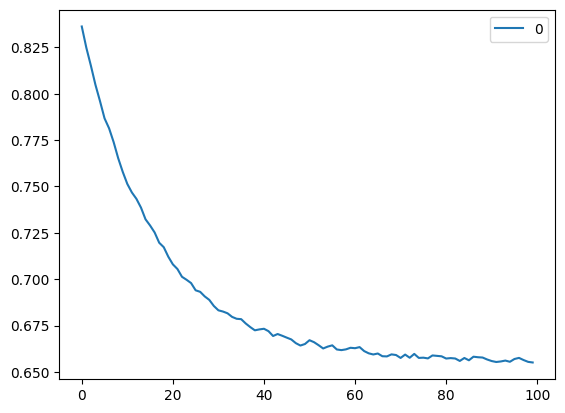

In [15]:
pd.DataFrame(train_loss_ep).plot()

In [16]:
df_norm[-config['seq_len']:,:].shape

(200, 1)

In [17]:
r = df_norm[-config['seq_len']:,:]
for i in range(0,300-6,config['pred_len']):
    x = torch.tensor(r[-config['seq_len']:,:]).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
        output = model(x.float().to(device))
    r = np.append(r, output.squeeze(0).to("cpu").detach().numpy(), axis=0)

<Axes: >

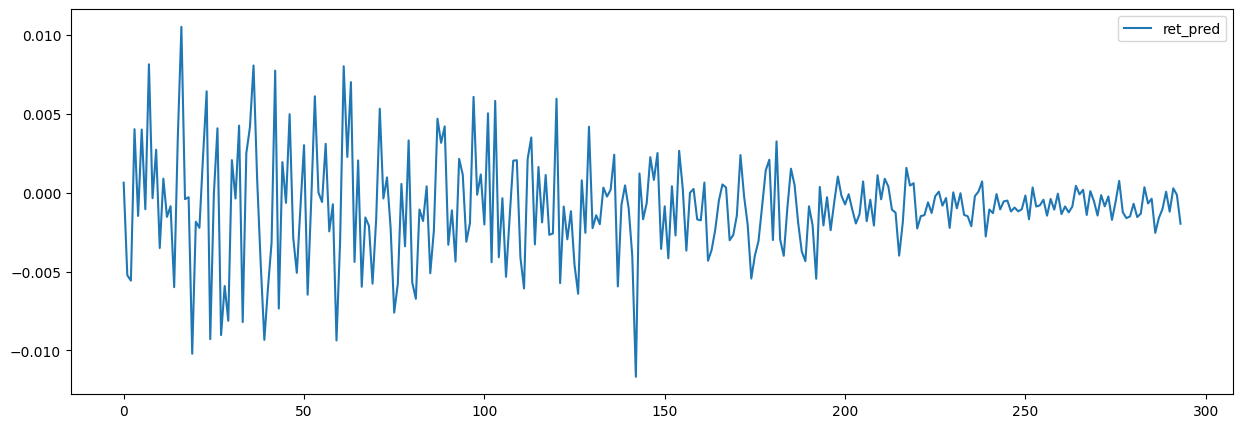

In [18]:
res_df = pd.DataFrame(scaler.inverse_transform(r[-294:]))
res_df.columns = ["ret_pred"]
res_df.plot(figsize=(15,5))

<Axes: >

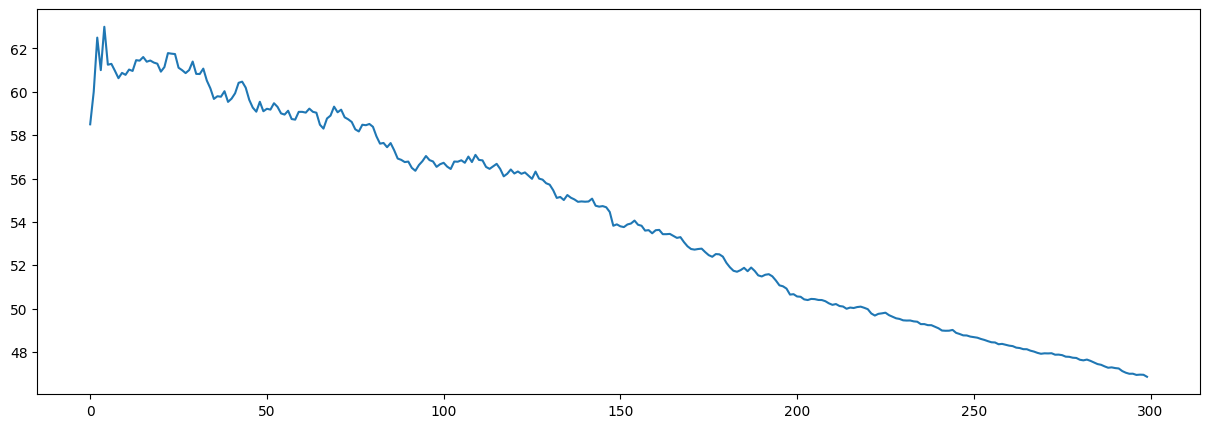

In [19]:
pred_df = pd.concat([ss.dropna()["price"], (res_df.add(1,fill_value=0).cumprod()*61.25)['ret_pred']], axis=0)
pred_df= pred_df.reset_index(drop=True)
pred_df.plot(figsize=(15,5))

In [20]:
ss["price"] = pred_df
ss

,id,price
0,3201,58.500000
1,3202,60.000000
2,3203,62.500000
3,3204,61.000000
4,3205,63.000000
...,...,...
295,3496,46.994400
296,3497,46.938118
297,3498,46.951210
298,3499,46.944779


In [21]:
df = pd.read_csv("/content/drive/MyDrive/superai_ss3/hack_out/stock_investment/stock-investment-prediction/train.csv")
df = pd.concat([df, ss]).reset_index(drop=True)
df

,id,price
0,1,0.455000
1,2,0.465000
2,3,0.450000
3,4,0.445000
4,5,0.440000
...,...,...
3495,3496,46.994400
3496,3497,46.938118
3497,3498,46.951210
3498,3499,46.944779


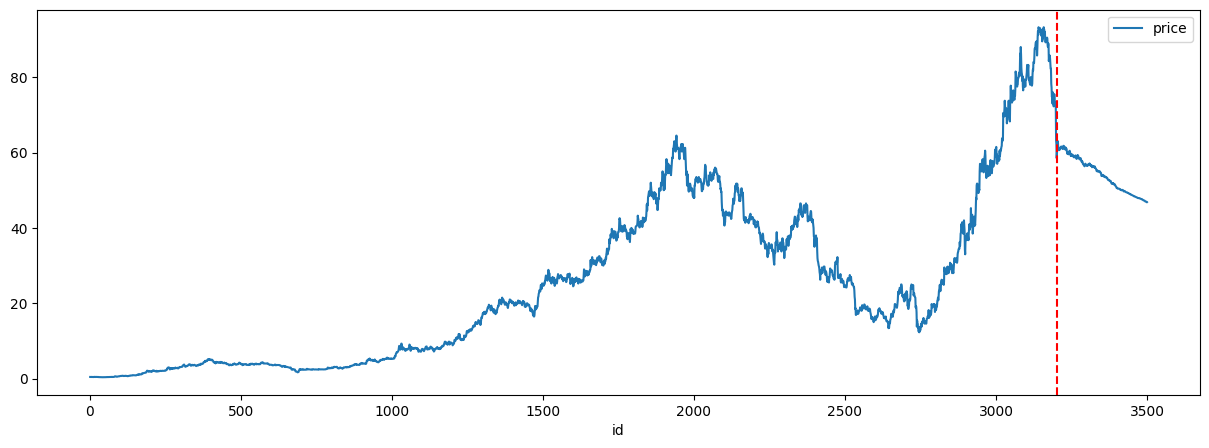

In [22]:
from matplotlib import pyplot as plt
df.plot(figsize=(15,5),x='id')
plt.axvline(x = 3201, color = 'r', label = 'axvline - full height',linestyle="dashed")

In [ ]:
ss.to_csv("submit.csv", index=False)